# The Data I use
- Training data
    - 20172018.csv：including electric-power data from 2017 to 2018
    - 20182019.csv：including electric-power data from 2018 to 2019
    - 19_201_323.csv：including electric-power data from 2019/02/01 to 2019/04/01
- Testing date
    - realTest.csv

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Visualization
Check the graph to see if there are any trendings
- Change DateFrame 'date' column to Timestamp type
- Plot tranding graph from 2017/1/1 to 2018/1/31
- Plot tranding graph from 2018/1/1 to 2019/1/31
- Plot overlaping graph of above

In [5]:
df_power = pd.read_csv("20182019.csv")
df_power2 = pd.read_csv('20172018.csv',nrows=396)

In [6]:
def toDate(date):
    return datetime.strptime(str(date), '%Y%m%d')
df_power['日期'] = df_power['日期'].apply(toDate)
df_power2['日期'] = df_power2['日期'].apply(toDate)

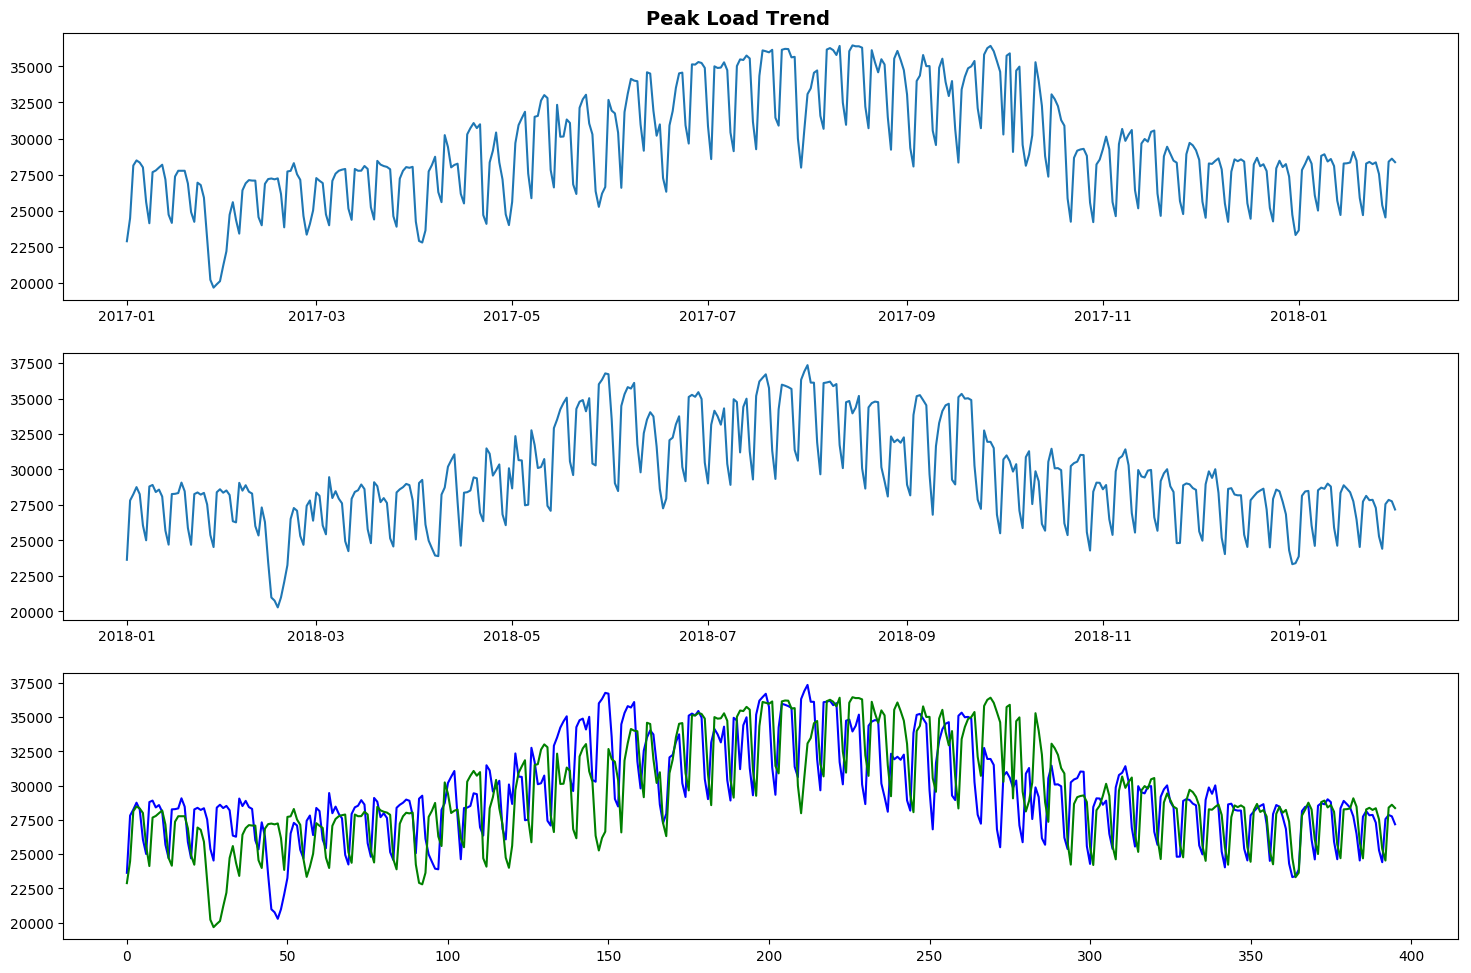

In [7]:
fig = plt.figure(figsize=(18,12),dpi=100)  
fig.suptitle('Peak Load Trend',y = 0.9, fontsize = 14, fontweight='bold')
ax1 = fig.add_subplot(3,1,2)
plt.plot(df_power['日期'],df_power['尖峰負載(MW)'])
ax2 = fig.add_subplot(3,1,1)
plt.plot(df_power2['日期'],df_power2['尖峰負載(MW)'])
ax3 = fig.add_subplot(3,1,3)
ax3.plot(df_power['尖峰負載(MW)'],'b')
ax3.plot(df_power2['尖峰負載(MW)'],'g')
#ax1.set_xlabel("date")      
#ax2.set_ylabel("MW")

# Date Preprocessing
- In the begining, I use the data from yesterday as feature column then I realize when forcasting the future one-week data it is impossible to know yesterday data. In this case, I need to find other methods to reach my goal but I can use previous method to create my base model.
- Only keep few columns like '尖峰負載(MW)' and '備轉容量(MW)' because in the recent data, other columns are not exist
- Remember to drop duplicated rows
- Condider Monday to Sunday as feature column, so I new a column to store what day it is

In [35]:
df_power = pd.read_csv("20182019.csv")
df_power2 = pd.read_csv('20172018.csv',nrows=396)
df_total = pd.concat([df_power,df_power2])
df_total.reset_index(inplace=True)
df_total.drop('index',axis=1,inplace=True)
df_total.set_index('日期',inplace = True)
df = df_total.sort_index()
df_noDup = df[~df.index.duplicated()]
df_noDup.head()

,淨尖峰供電能力(MW),尖峰負載(MW),備轉容量(MW),備轉容量率(%),工業用電(百萬度),民生用電(百萬度),核一#1(萬瓩),核一#2(萬瓩),核二#1(萬瓩),核二#2(萬瓩),...,大觀二,明潭,碧海,立霧,龍澗,卓蘭,水里,其他小水力,風力發電,太陽能發電
日期,,,,,,,,,,,,,,,,,,,,,
20170101,24957.0,22886,2071.0,9.05,268.503,196.229,0,62.8,0.0,0.0,...,28.6,65.9,0.0,0.0,0.6,2.0,0.0,6.2,12.2,0.0
20170102,26035.0,24483,1552.0,6.34,280.534,205.022,0,62.8,0.0,0.0,...,49.3,94.0,0.0,0.0,0.7,2.2,0.0,6.0,12.7,0.0
20170103,29152.0,28131,1021.0,3.63,320.449,234.193,0,62.7,0.0,0.0,...,39.5,68.3,0.0,0.0,0.4,3.9,0.0,4.0,25.2,0.0
20170104,29757.0,28485,1272.0,4.47,329.623,240.898,0,62.8,0.0,0.0,...,40.9,68.3,0.0,0.0,0.4,3.1,0.0,15.9,9.3,0.0
20170105,30065.0,28336,1729.0,6.10,330.137,241.273,0,62.8,0.0,0.0,...,26.3,61.5,0.0,0.0,0.3,2.1,0.0,9.3,6.5,0.0


In [103]:
df_twoCol = df_noDup[['尖峰負載(MW)','備轉容量(MW)']]
num = 7
date_list = []
for row in df_twoCol.index:
    date_list.append(num)
    num += 1
    if num == 8:
        num = 1
        
df_twoCol['星期'] = date_list
df_twoCol.head(7)

,尖峰負載(MW),備轉容量(MW),星期
日期,,,
20170101,22886,2071.0,7
20170102,24483,1552.0,1
20170103,28131,1021.0,2
20170104,28485,1272.0,3
20170105,28336,1729.0,4
20170106,28002,1152.0,5
20170107,25600,2214.0,6


In [37]:
peak = df_twoCol.drop(20190131,axis=0)['尖峰負載(MW)']  # Keep peak values of all date except 20190131
capacity = df_twoCol.drop(20190131,axis=0)['備轉容量(MW)']
df_withYesterday = df_twoCol.drop(20170101,axis=0)
df_withYesterday['Yesterday peak'] = peak.values
df_withYesterday['Yesterday capacity'] = capacity.values
df_withYesterday.head()

,尖峰負載(MW),備轉容量(MW),星期,Yesterday peak,Yesterday capacity
日期,,,,,
20170102,24483,1552.0,1,22886,2071.0
20170103,28131,1021.0,2,24483,1552.0
20170104,28485,1272.0,3,28131,1021.0
20170105,28336,1729.0,4,28485,1272.0
20170106,28002,1152.0,5,28336,1729.0


In [38]:
df_withYesterday.drop("備轉容量(MW)",axis=1,inplace=True)
df_withYesterday.head()

,尖峰負載(MW),星期,Yesterday peak,Yesterday capacity
日期,,,,
20170102,24483,1,22886,2071.0
20170103,28131,2,24483,1552.0
20170104,28485,3,28131,1021.0
20170105,28336,4,28485,1272.0
20170106,28002,5,28336,1729.0


# Split train & test data
- Split dataframe into training set and testing set

In [41]:
from sklearn.model_selection import train_test_split
X = df_withYesterday.loc[:,df_withYesterday.columns != '尖峰負載(MW)']
y = y = df_withYesterday['尖峰負載(MW)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Use linear regression to train model
- Use sklearn LinearRegression model to train
- Visualize the results
- Calculate the RMSE result

In [39]:
from sklearn.linear_model import LinearRegression

Text(0, 0.5, 'predicted y')

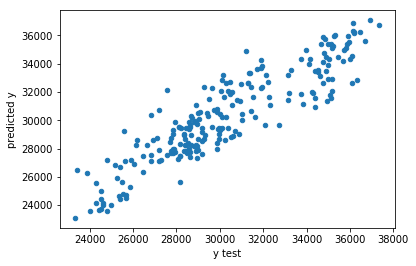

In [43]:
lm = LinearRegression()
lm.fit(X_train,y_train)
prediction = lm.predict(X_test)
plt.scatter(y_test,prediction, s = 20)
plt.xlabel('y test')
plt.ylabel('predicted y')

In [44]:
from sklearn import metrics
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

RMSE: 1477.3865440844195


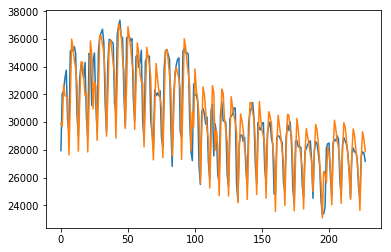

In [53]:
plt.plot(y_test.values)
plt.plot(prediction)

# Feature selection
- Find out that I can use previous one-week data as feature column to predict future one-week data
- Delete the first 7 days data because they don't have previous 7 day data. However, the **result is worse** than my base model
- Consider adding '備轉容量(MW)' as feature column but the **result gets even worse**. Determine not to use '備轉容量(MW)' as features
- Suddenly come up an idea that wheather the date is holiday might help, so I create a holiday column if true the valuse is set to 1 otherwise 0. Find out adding this column can **improve my result**

In [93]:
df_new = df.drop_duplicates()
df_new = df_new[['尖峰負載(MW)','備轉容量(MW)']]
df_tmp = pd.read_csv('19_201_323.csv')
df_tmp.set_index('日期',inplace=True)
df_tmp.drop('備轉容量率(%)',axis=1,inplace=True)
df_all = pd.concat([df_new,df_tmp])
num = 7
date_list = []
for row in df_all.index:
    date_list.append(num)
    num += 1
    if num == 8:
        num = 1
        
df_all['星期'] = date_list
firstDay = int(df_all.iloc[0]['星期'])
firstDay = firstDay % 7
num = firstDay
tmp_list = []
for i in range(0,7):
    tmp_list.append([])
scale = 0
for row in df_all.index[:-7]:
    tmp_list[0].append(df_all['尖峰負載(MW)'].values[0 + scale])
    tmp_list[1].append(df_all['尖峰負載(MW)'].values[1 + scale])
    tmp_list[2].append(df_all['尖峰負載(MW)'].values[2 + scale])
    tmp_list[3].append(df_all['尖峰負載(MW)'].values[3 + scale])
    tmp_list[4].append(df_all['尖峰負載(MW)'].values[4 + scale])
    tmp_list[5].append(df_all['尖峰負載(MW)'].values[5 + scale])
    tmp_list[6].append(df_all['尖峰負載(MW)'].values[6 + scale])
    num += 1
    num = num % 7
    if (num == int(firstDay)) and (scale + 7) < 819 :
        scale += 7
df_clean = df_all.drop([20170101, 20170102, 20170103, 20170104, 20170105, 20170106,
            20170107,],axis=0)
df_clean['last Sun'] = tmp_list[0]
df_clean['last Mon'] = tmp_list[1]
df_clean['last Tue'] = tmp_list[2]
df_clean['last Wed'] = tmp_list[3]
df_clean['last Thu'] = tmp_list[4]
df_clean['last Fri'] = tmp_list[5]
df_clean['last Sat'] = tmp_list[6]
df_clean.drop([20190401],axis=0,inplace=True)
df_clean.drop('備轉容量(MW)',axis=1,inplace=True)
df_clean.tail(1)

,尖峰負載(MW),星期,last Sun,last Mon,last Tue,last Wed,last Thu,last Fri,last Sat
日期,,,,,,,,,
20190331,24466.0,7,24812.0,28535.0,28756.0,29140.0,30093.0,29673.0,25810.0


## The result of condisering previous one week as feature (only 尖峰負載)  

RMSE: 1956.5660881910212


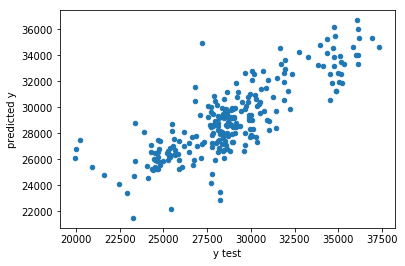

In [94]:
X = df_clean.loc[:,df_clean.columns != '尖峰負載(MW)']
y = df_clean['尖峰負載(MW)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle=False)

lm = LinearRegression()
lm.fit(X_train,y_train)

prediction = lm.predict(X_test)
plt.scatter(y_test,prediction, s = 20)
plt.xlabel('y test')
plt.ylabel('predicted y')
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

## The result of condisering previous one week as feature (尖峰負載 and 備轉容量)

RMSE: 2122.914617339425


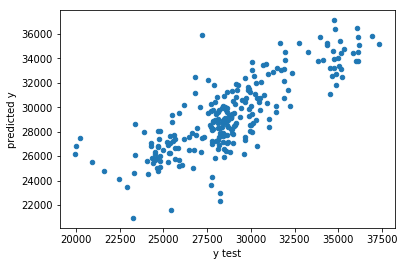

In [95]:
firstDay = int(df_all.iloc[0]['星期'])
firstDay = firstDay % 7
num = firstDay
tmp_list2 = []
for j in range(0,7):
    tmp_list2.append([])
scale = 0
for row in df_all.index[:-7]:
    tmp_list2[0].append(df_all['備轉容量(MW)'].values[0 + scale])
    tmp_list2[1].append(df_all['備轉容量(MW)'].values[1 + scale])
    tmp_list2[2].append(df_all['備轉容量(MW)'].values[2 + scale])
    tmp_list2[3].append(df_all['備轉容量(MW)'].values[3 + scale])
    tmp_list2[4].append(df_all['備轉容量(MW)'].values[4 + scale])
    tmp_list2[5].append(df_all['備轉容量(MW)'].values[5 + scale])
    tmp_list2[6].append(df_all['備轉容量(MW)'].values[6 + scale])
    num += 1
    num = num % 7
    if (num == int(firstDay)) and (scale + 7) < 819 :
        scale += 7
df_clean['last Sun cap'] = tmp_list2[0][:-1]
df_clean['last Mon cap'] = tmp_list2[1][:-1]
df_clean['last Tue cap'] = tmp_list2[2][:-1]
df_clean['last Wed cap'] = tmp_list2[3][:-1]
df_clean['last Thu cap'] = tmp_list2[4][:-1]
df_clean['last Fri cap'] = tmp_list2[5][:-1]
df_clean['last Sat cap'] = tmp_list2[6][:-1]
X = df_clean.loc[:,df_clean.columns != '尖峰負載(MW)']
y = df_clean['尖峰負載(MW)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle=False)

lm = LinearRegression()
lm.fit(X_train,y_train)

prediction = lm.predict(X_test)
plt.scatter(y_test,prediction, s = 20)
plt.xlabel('y test')
plt.ylabel('predicted y')
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

## Add holiday or not as feature without what day it is

In [104]:
df_last = df_all
holiday = [20170101,20170102,20170127,20170128,20170129,20170130,
           20170131,20170201,20170225,20170226,20170227,20170228,
           20170401,20170402,20170403,20170404,20170529,20170530,
           20171004,20171009,20171010,20180101,20180215,20180216,
           20180219,20180220,20180228,20180404,20180405,20180406,
           20180618,20180924,20181010,20181231,20190101,20190204,
           20190205,20190206,20190207,20190208,20190228,20190301]
holiday_list = []
for row in df_last.index:
    if df_last.loc[row]['星期'] == 7 or df_last.loc[row]['星期'] == 6:
        holiday_list.append(1)
    elif row in holiday: 
        holiday_list.append(1)
    else:
        holiday_list.append(0)
df_last['holiday'] = holiday_list

RMSE: 1305.1836433168826


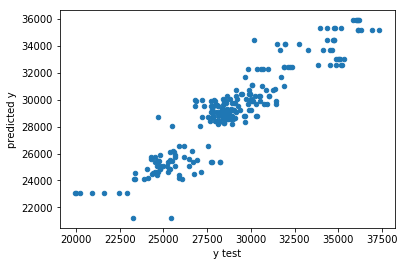

In [105]:
df_test = df_last.drop(['備轉容量(MW)','星期'],axis=1)

df_test = df_test.iloc[7:]
df_test['last Sun'] = tmp_list[0]
df_test['last Mon'] = tmp_list[1]
df_test['last Tue'] = tmp_list[2]
df_test['last Wed'] = tmp_list[3]
df_test['last Thu'] = tmp_list[4]
df_test['last Fri'] = tmp_list[5]
df_test['last Sat'] = tmp_list[6]

df_test = df_test.iloc[:-5]

X = df_test.loc[:,df_test.columns != '尖峰負載(MW)']
y = df_test['尖峰負載(MW)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle=False)

lm = LinearRegression()
lm.fit(X_train,y_train)

prediction = lm.predict(X_test)
plt.scatter(y_test,prediction, s = 20)
plt.xlabel('y test')
plt.ylabel('predicted y')
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

## Add holiday or not as feature without what day it is (slightly better)

RMSE: 1304.4736920428675


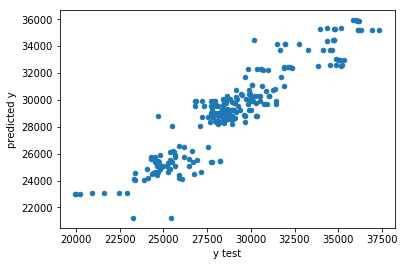

In [101]:
df_test = df_last.drop(['備轉容量(MW)'],axis=1)

df_test = df_test.iloc[7:]
df_test['last Sun'] = tmp_list[0]
df_test['last Mon'] = tmp_list[1]
df_test['last Tue'] = tmp_list[2]
df_test['last Wed'] = tmp_list[3]
df_test['last Thu'] = tmp_list[4]
df_test['last Fri'] = tmp_list[5]
df_test['last Sat'] = tmp_list[6]

df_test = df_test.iloc[:-5]

X = df_test.loc[:,df_test.columns != '尖峰負載(MW)']
y = df_test['尖峰負載(MW)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle=False)

lm = LinearRegression()
lm.fit(X_train,y_train)

prediction = lm.predict(X_test)
plt.scatter(y_test,prediction, s = 20)
plt.xlabel('y test')
plt.ylabel('predicted y')
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

## 看一下預測結果和原本趨勢的符合程度

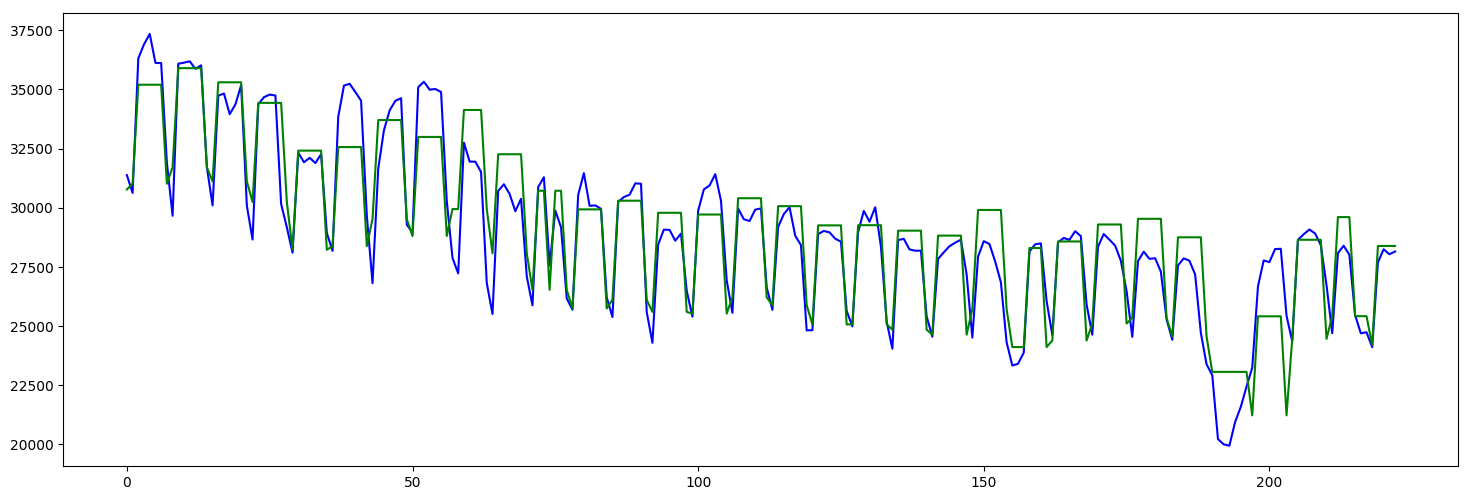

In [106]:
fig = plt.figure(figsize=(18,6),dpi=100)  
#fig.suptitle('Peak Load Trend',y = 0.9, fontsize = 14, fontweight='bold')
ax1 = fig.add_subplot(1,1,1)
ax1.plot(y_test[:-20].values,'b')
ax1.plot(prediction[:-20],'g')